# SPACEc: Dataframe Preprocessing

## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import pathlib
import numpy as np

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Helper functions - used by other functions to execute steps like table formatting etc. KEY: hf
from spacec.helperfunctions_hf import \
    hf_make_anndata

# Preprocessing functions - to normalize and prepare data for further analysis KEY: pp
from spacec.preprocessing_pp import \
    pp_read_segdf, \
    pp_filter_data, \
    pp_format, \
    pp_remove_noise

# tools - perform calculation on the data KEY: tl
# from spacec.tools_tl import *

# plotting functions - used to visualize results KEY: pl
from spacec.plot_pl import \
    pl_zcount_thres, \
    pl_coordinates_on_image

In [14]:
root_path = pathlib.Path("..")

data_path = root_path / 'data' # where the data is stored

# where you want to store the output
output_dir = root_path / '_out'
output_dir.mkdir(exist_ok=True, parents=True)

out_fname = "tonsil"

## 2.1 Load data

Read and concatenate the csv files (outputs from the cell segmentation algorithms). 

In [15]:
#read in segmentation csv files
df_seg = pp_read_segdf(
    segfile_list = [
        data_path / "processed/cellseg/reg010_X01_Y01_Z01_compensated.csv", 
        data_path / "processed/cellseg/reg001_X01_Y01_Z01_compensated.csv"
    ],
    seg_method = 'cellseg',
    region_list =["reg010", "reg001"],
    meta_list = ["tonsillitis", "tonsil"]
)

#Get the shape of the data
print(df_seg.shape)

#See what it looks like
df_seg.head()

[PosixPath('../data/processed/cellseg/reg010_X01_Y01_Z01_compensated.csv'), PosixPath('../data/processed/cellseg/reg001_X01_Y01_Z01_compensated.csv')]
(52218, 71)


,cell_id,region,tile_num,x,y,z,x_tile,y_tile,area,DAPI,FoxP3,HLA-DR,CD103,CHGA,EGFR,CD206,GFAP,PD-1,BCL2,panCK,CD45RO,CD11b,CD56,CD163,CD21,CD8,S100,Vimentin,PDGFRb,CCR7,CD57,CD34,Synaptophysin,CD31,CXCR5,CD3,CD38,LAG3,CD25,CD16,IL-10,Ki67,CLEC9A,p53,CD69,CD11c,CD68,Ox40,aSMA,CD20,CD4,MUC-1,Podoplanin,CD45RA,CD15,betaCatenin,PAX5,MCT,FAP,CD138,Tbet,GranzymeB,IDO-1,CD45,CollagenIV,PD-L1,Arginase-1,GATA3,region_num,unique_region,condition
0,1.0,10.0,1.0,599.0,1721.0,1.0,599.0,1721.0,20.0,58.452089,1.559916,11.933356,14.856285,11.502523,3.699247,3.358400,0.641744,12.537453,15.666234,3.058075,7.164496,3.806387,5.594728,0.589309,17.146743,1.199014,1.686147,2.264592,4.238489,23.903992,0.370337,2.065603,1.537209,0.341102,4.684418,12.226497,0.422911,2.373062,7.071737,4.478520,0.712452,0.055299,2.675641,20.747212,13.915008,3.704814,1.627121,21.879159,4.843863,0.288725,30.105365,0.083951,4.941775,7.228279,0.011452,7.998449,4.675498,0.709042,10.224476,1.034401,3.225084,0.000000,4.324554,18.868577,5.933131,12.849905,2.004022,11.934559,0,reg010,tonsillitis
1,2.0,10.0,1.0,2159.0,615.0,1.0,2159.0,615.0,74.0,86.372276,1.153285,3.799384,12.669083,30.962962,5.070284,3.894757,0.466634,10.146010,21.554572,6.197358,6.433258,2.780795,6.858500,0.829138,19.556508,0.433378,2.157382,3.399789,3.817812,3.558099,0.826352,2.009586,3.389711,1.067154,5.652756,0.000000,1.094137,4.808818,7.967119,5.357545,0.918181,6.101933,3.382545,29.087630,7.668043,0.474714,3.994390,12.499891,13.072886,26.229659,12.377302,0.392552,10.122428,77.325212,0.461776,12.432507,25.436481,1.451075,12.846941,2.245027,4.086855,0.000000,2.926918,34.616144,5.589555,10.254221,2.166106,11.117285,0,reg010,tonsillitis
2,3.0,10.0,1.0,558.0,1027.0,1.0,558.0,1027.0,68.0,67.217662,6.121650,3.850919,12.132407,22.226315,4.926846,4.555788,0.616905,8.800478,24.980589,4.680051,7.054401,5.266627,5.227524,0.914604,15.422960,0.000000,1.911209,2.904769,4.441544,8.649168,0.037307,2.244729,2.328252,1.483087,4.372043,9.552101,1.844263,3.016785,7.503354,5.131185,0.289892,0.700753,3.207078,24.985188,24.070115,1.809421,2.772327,25.387036,9.074168,6.410052,16.430936,0.000000,5.841691,65.714553,0.377306,9.871123,12.254549,2.019151,10.702579,1.236823,4.661284,0.020250,4.860737,22.324609,5.276936,11.147313,1.981664,7.081764,0,reg010,tonsillitis
3,4.0,10.0,1.0,1052.0,990.0,1.0,1052.0,990.0,147.0,48.907490,0.000000,1.708429,13.162115,15.039619,6.742039,2.309123,0.661829,23.700494,4.407419,2.666264,7.771704,6.183990,3.149796,0.370799,140.311155,0.361604,0.962647,2.311832,5.695978,2.828487,0.156112,1.609042,1.169546,0.455315,10.557736,0.726423,0.738971,2.660764,4.506637,3.598852,0.227795,0.000000,3.092990,20.057589,10.150258,11.335324,4.764030,7.695818,5.479733,15.245209,14.108226,0.246796,37.418185,35.182670,0.100703,9.647718,3.481473,0.754452,9.539534,0.755100,2.534074,0.000000,3.813063,24.231576,3.899519,17.289386,2.361467,6.886369,0,reg010,tonsillitis
4,5.0,10.0,1.0,1008.0,2100.0,1.0,1008.0,2100.0,46.0,70.925956,2.012432,1.681294,17.635858,19.671403,3.918691,3.314609,0.828496,11.459186,29.243100,3.596416,7.375297,6.393556,5.510327,0.877652,14.594171,0.000000,1.465649,2.187545,3.744978,4.081971,0.299185,2.347332,2.615489,3.729941,6.236342,10.048736,1.485019,3.885060,7.881074,5.483322,0.916601,0.000000,4.723552,22.916490,9.646223,0.000000,1.441824,18.419888,7.399584,11.649624,12.274215,0.199495,5.741447,125.709261,0.138541,11.403171,14.450424,1.928702,10.599415,1.525879,3.220384,0.162383,3.272036,43.777483,4.648866,9.633944,2.704003,6.731205,0,reg010,tonsillitis


# 2.2 Filter cells by DAPI intensity and area

Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.

In [18]:
# print smallest 1% of cells by area
one_percent_area = np.percentile(df_seg.area, 1)
one_percent_area

27.0

In [19]:
# print smallest 1% of cells by DAPI intensity
one_percent_nuc = np.percentile(df_seg.DAPI, 1)
one_percent_nuc

0.0

If necessary filter the dataframe to remove too small objects or cells without a nucleus. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


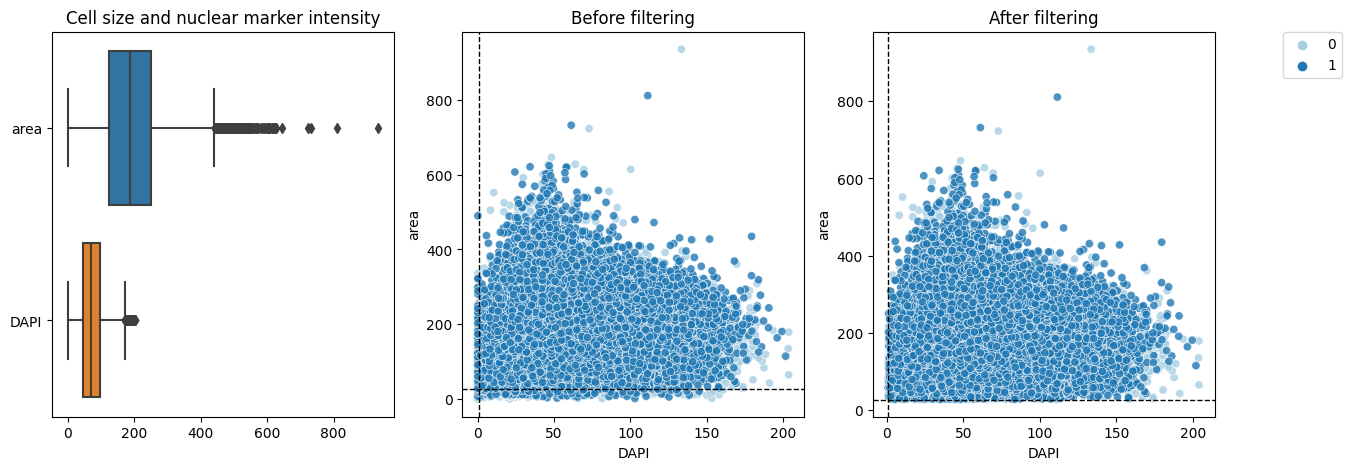

<Figure size 640x480 with 0 Axes>

Percentage of cells kept:  97.49703167490138 %


In [21]:
df_filt = pp_filter_data(
    df_seg, 
    nuc_thres=1,
    size_thres=one_percent_area,
    nuc_marker="DAPI",
    cell_size = "area",
    region_column = "region_num",
    color_by = "region_num",
    log_scale=False)

## 2.3 Normalize data

Normalize data with one of the four available methods (zscore as default)

In [22]:
df_filt.columns

Index(['cell_id', 'region', 'tile_num', 'x', 'y', 'z', 'x_tile', 'y_tile',
       'area', 'DAPI', 'FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206',
       'GFAP', 'PD-1', 'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163',
       'CD21', 'CD8', 'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34',
       'Synaptophysin', 'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16',
       'IL-10', 'Ki67', 'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40',
       'aSMA', 'CD20', 'CD4', 'MUC-1', 'Podoplanin', 'CD45RA', 'CD15',
       'betaCatenin', 'PAX5', 'MCT', 'FAP', 'CD138', 'Tbet', 'GranzymeB',
       'IDO-1', 'CD45', 'CollagenIV', 'PD-L1', 'Arginase-1', 'GATA3',
       'region_num', 'unique_region', 'condition'],
      dtype='object')

In [25]:
# This is to normalize the data 
dfz = pp_format(
    data=df_filt, 
    list_out=['cell_id', 'tile_num', 'z', 'x_tile', 'y_tile'], 
    # in case of other segmentation methods: ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length', "first_index", "filename", "label"]
    list_keep = ["DAPI",'x','y', 'area','region_num', 'region',"unique_region", 'condition'], # This is a list of meta information that you would like to keep but don't want to normalize
    method = "zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
print(dfz.shape)

(50911, 66)


## 2.4 Remove noisy cells

This section is used to remove noisy cells. This is very important to ensure proper identification of the cells via clustering.

In [26]:
dfz.columns

Index(['FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206', 'GFAP', 'PD-1',
       'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163', 'CD21', 'CD8',
       'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34', 'Synaptophysin',
       'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16', 'IL-10', 'Ki67',
       'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40', 'aSMA', 'CD20', 'CD4',
       'MUC-1', 'Podoplanin', 'CD45RA', 'CD15', 'betaCatenin', 'PAX5', 'MCT',
       'FAP', 'CD138', 'Tbet', 'GranzymeB', 'IDO-1', 'CD45', 'CollagenIV',
       'PD-L1', 'Arginase-1', 'GATA3', 'DAPI', 'x', 'y', 'area', 'region_num',
       'region', 'unique_region', 'condition'],
      dtype='object')

In [27]:
# get the column index for the last marker 
col_num_last_marker = dfz.columns.get_loc('GATA3')
print(col_num_last_marker)

57


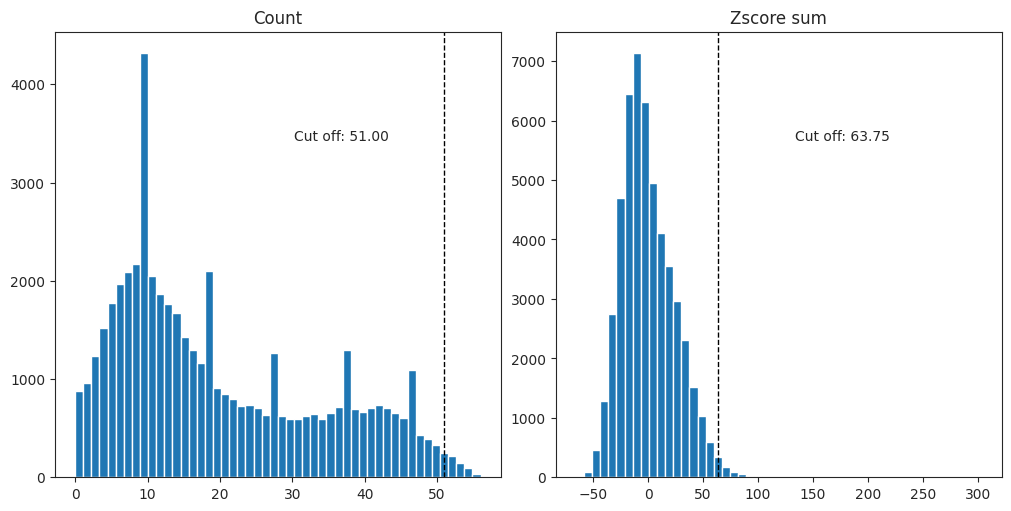

In [30]:
# This function helps to figure out what the cut-off should be
# This is to remove top 1 % of all cells that are highly expressive for all antibodies
pl_zcount_thres(dfz = dfz, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=50) 

This step removes the remaining noisy cells from the analysis

In [33]:
df_nn,cc = pp_remove_noise(
    df=dfz, 
    col_num=col_num_last_marker, # this is the column index that has the last protein feature
    z_count_thres=51, # number obtained from the function above
    z_sum_thres=63 # number obtained from the function above
)
print(df_nn.shape)

1.7000000000000002% cells are removed.
(50065, 66)


## 2.5 Save denoise data

#### Save as dataframe 

In [34]:
#Save the df as a backup. We strongly recommend the Anndata format for further analysis!
df_nn.to_csv(output_dir / "df_nn_demo.csv")

#### Save as anndata

In [37]:
# inspect which markers work, and drop the ones that did not work from the clustering step
# make an anndata to be compatible with the downstream clustering step
adata = hf_make_anndata(
    df_nn = df_nn,
    col_sum = col_num_last_marker, # this is the column index that has the last protein feature # the rest will go into obs
    nonFuncAb_list = [] # Remove the antibodies that are not working
)
adata

AnnData object with n_obs × n_vars = 50065 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'region', 'unique_region', 'condition'

In [38]:
# save the anndata object to a file
adata.write_h5ad(output_dir / 'adata_nn_demo.h5ad')

## 2.6 Show the spatial distribution for size (Optional)

In [42]:
import pickle
with open(output_dir / 'overlay_tonsil1.pickle', 'rb') as f:
    overlay_data1 = pickle.load(f)

with open(output_dir / 'overlay_tonsil2.pickle', 'rb') as f:
    overlay_data2 = pickle.load(f)

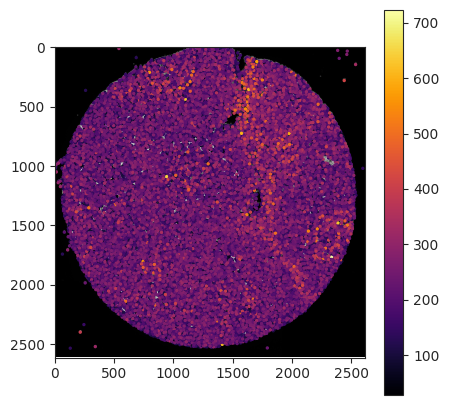

In [43]:
pl_coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg010',:], 
    overlay_data = overlay_data1, color='area',  
    scale=False, # whether to scale to 1 or not
    dot_size=2,
    convert_to_grey=True, 
    fig_width=5, fig_height=5)

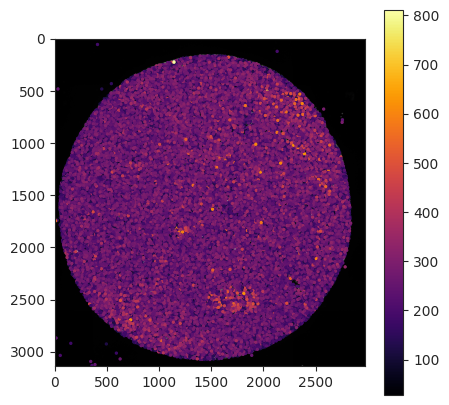

In [44]:
pl_coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg001',:], 
    overlay_data = overlay_data2, 
    color='area', 
    scale=False, # whether to scale to 1 or not
    dot_size=2,
    convert_to_grey=True, 
    fig_width=5, fig_height=5 )